# Jupyter notebook de avaliação dos dados da produção da Brazilian FISH mensalmente (toneladas)
### ainda não iniciado

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import xlsxwriter
from tabulate import tabulate
import seaborn as sns

#from google.colab import drive
#from electre_tree import tree_e_tri_b , util_e_tri_b
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
#from yellowbrick.cluster import KElbowVisualizer
#from yellowbrick.cluster import SilhouetteVisualizer
# Required Libraries
import os


In [2]:
dataset = pd.DataFrame()
file = pd.ExcelFile('data\C_DADOS_BZF.xlsx')
sheets_list = ['Produção', 'Industria', 'Descrição']
for sheet in sheets_list:
    if 'Descrição' != sheet:
        temp_df = pd.read_excel(file, sheet_name=sheet)
        dataset = pd.concat([dataset, temp_df])
first_list = temp_df.columns.tolist()
temp_df = dataset.reset_index(drop=True)
#dataset.head()
len(dataset)

4504

In [3]:
xls = pd.ExcelFile('data\C_DADOS_BZF.xlsx')
prod= pd.read_excel(xls, 'Produção')
ind= pd.read_excel(xls, 'Industria')

In [4]:
## Eliminar espacos dos nomes das colunas
prod.columns = prod.columns.str.strip()

In [5]:
for col in prod.select_dtypes(include='object').columns:
    print(col)

Unidade
Tanque
Fase
Tamanho
Lote
Data Encerramento
Curva
Status
Espécie
Tipo Tanque
Linha
Produto Origem
Fornecedor Origem


In [6]:
prod = prod.drop(columns=[
'Unidade',
'Tanque',
'Tamanho',
'Lote',
'Data Encerramento',
'Curva',
'Status',
'Espécie',
'Tipo Tanque',
'Linha',
'Produto Origem',
'Fornecedor Origem',
'Peso Estimado Biometria',
'Biomassa Biometria',
'Peso Médio Últ. Biometria',
'Peso Médio Biometria',
'Biomassa Despesca',
'Peso Médio Despesca',
'Densidade',
'Peso Médio Atual',
'Custo Insumos',
'Custo Alevinos',
'Custo Indireto',
'Densidade Máxima', 
'Sequência',
'Outras Saídas',
'Biomassa Atual', 
'Saldo'
])

prod.head()

,ID Lote,Fase,nº Dias,Peso Médio Inicial,Data Entrada,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,...,Custo Ração,Custos Totais (Peixe),Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Últ. Biometria,Ração Nominal,Ração Real,% Nominal/Real,Data Povoamento
0,7201,Fase 3,85,46.0,2022-01-03,8089,2254,204,72.184448,5839,...,15951.667908,24010.032110,19125.523013,7.737645,4.112011,NaT,5279.906040,4239.251772,80.290288,2021-06-08
1,7202,Fase 3,63,84.0,2022-01-03,8176,1549,235,81.054305,6627,...,14540.378988,22633.531848,19979.966837,6.981896,3.415351,NaT,4359.112894,3821.237976,87.660909,2021-06-08
2,7203,Fase 3,45,188.0,2022-01-03,8516,1307,98,84.652419,7209,...,9409.738452,17717.644222,21469.799126,7.118032,2.457712,NaT,3704.695446,2902.144641,78.336929,2021-06-08
3,7206,Fase 3,63,80.0,2022-01-04,8152,1590,157,80.495584,6562,...,14890.776107,22797.248557,19860.435832,7.318226,3.474131,NaT,4298.687760,3828.892759,89.071200,2021-07-08
4,7207,Fase 4,63,590.0,2022-01-04,8100,328,328,96.604938,7825,...,21862.674185,75240.713679,57577.926096,8.175779,9.615427,NaT,6845.448715,6354.039134,92.821368,2021-02-25


In [7]:
prod_num_286 =prod[prod['Saldo Final'] != 0]
prod_num_286.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1684 entries, 0 to 1920
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID Lote                         1684 non-null   int64         
 1   Fase                            1684 non-null   object        
 2   nº Dias                         1684 non-null   int64         
 3   Peso Médio Inicial              1684 non-null   float64       
 4   Data Entrada                    1684 non-null   datetime64[ns]
 5   Quantidade Inicial              1684 non-null   int64         
 6   Mortalidade                     1684 non-null   int64         
 7   Mortalidade Coletada            1684 non-null   int64         
 8   Sobrevivência                   1684 non-null   float64       
 9   Saldo Final                     1684 non-null   int64         
 10  Peso Médio Saída                1684 non-null   float64       
 11  Peso

In [8]:
prod_num_final =prod_num_286[prod_num_286['Custo Entrada/Kg'] != 0]
prod_num_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584 entries, 0 to 1920
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID Lote                         1584 non-null   int64         
 1   Fase                            1584 non-null   object        
 2   nº Dias                         1584 non-null   int64         
 3   Peso Médio Inicial              1584 non-null   float64       
 4   Data Entrada                    1584 non-null   datetime64[ns]
 5   Quantidade Inicial              1584 non-null   int64         
 6   Mortalidade                     1584 non-null   int64         
 7   Mortalidade Coletada            1584 non-null   int64         
 8   Sobrevivência                   1584 non-null   float64       
 9   Saldo Final                     1584 non-null   int64         
 10  Peso Médio Saída                1584 non-null   float64       
 11  Peso

In [9]:
num_list = ['Fase',
'nº Dias',
'Peso Médio Inicial',
'Quantidade Inicial',
'Mortalidade',
'Mortalidade Coletada',
'Sobrevivência',
'Saldo Final',
'Peso Médio Saída',
'Peso Médio Entrada',
'Conversão Alimentar',
'Biomassa Final',
'Biomassa Inicial',
'Biomassa Ganha',
'GPD Fase',
'GPD Real',
'Conversão Alimentar',
'Conversão Acumulada'
]
#ind_new = ind[num_list]
temp_num1 = prod_num_final.reset_index(drop=True)
temp_num1 = prod_num_final[num_list]


In [10]:
num_list = ['Fase',
'Metragem Tanque',
'Custo Total Entrada (Biomassa)',
'Custo Total Entrada (Peixe)',
'Custo Entrada/Kg',
'Custo Entrada/Unidades',
'Custo Ração',
'Custos Totais (Peixe)',
'Custos Totais (Biomassa)',
'Custo/Kg',
'Custo/Peixe',
'Ração Nominal',
'Ração Real',
'% Nominal/Real',
'Conversão Alimentar',
'Conversão Acumulada'
]
#ind_new = ind[num_list]
temp_num2 = prod_num_final.reset_index(drop=True)
temp_num2 = prod_num_final[num_list]

In [11]:
prod_fase2 = temp_num1[temp_num1['Fase'] != 'Fase 2']
prod_fase2.describe()

,nº Dias,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Peso Médio Saída,Peso Médio Entrada,Conversão Alimentar,Biomassa Final,Biomassa Inicial,Biomassa Ganha,GPD Fase,GPD Real,Conversão Alimentar,Conversão Acumulada
count,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000
mean,72.592898,225.668951,7770.333609,793.064410,281.369116,91.933883,7118.706854,622.405823,226.050741,1.811221,4532.375889,1727.003723,2808.880036,5.499975,5.480070,1.811221,1.645581
std,20.982722,171.436239,1254.136179,820.857365,342.599771,12.558556,1460.651375,283.163096,171.583250,0.412867,2488.788743,1373.956995,1367.148071,1.522621,1.429254,0.412867,0.846658
min,22.000000,18.000000,3028.000000,0.000000,0.000000,51.987805,2623.000000,224.860909,27.743171,0.679229,842.348000,217.750000,194.962000,2.052131,1.993773,0.679229,-25.249060
25%,57.000000,73.000000,8025.000000,110.000000,56.000000,83.264755,6440.000000,355.607690,71.739377,1.529309,2364.617000,583.673800,1753.483000,4.320985,4.322429,1.529309,1.440851
50%,69.000000,128.400000,8100.000000,472.000000,151.000000,93.934348,7313.000000,458.564741,126.671676,1.705769,3271.373000,932.508000,2425.043000,5.411957,5.403632,1.705769,1.634802
75%,85.000000,385.500000,8170.000000,1342.000000,353.000000,100.754471,8041.500000,888.000000,384.715523,1.993990,7145.673500,3036.423500,3662.736500,6.591693,6.553946,1.993990,1.826566
max,172.000000,656.000000,11930.000000,3937.000000,2377.000000,166.161473,12427.000000,1173.814607,638.706453,4.515163,11395.024000,5463.495000,8246.090000,21.704905,10.167249,4.515163,8.112428


C:\Users\crist\AppData\Local\Temp\ipykernel_15612\4109147485.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(prod_fase2.corr(),


<Axes: >

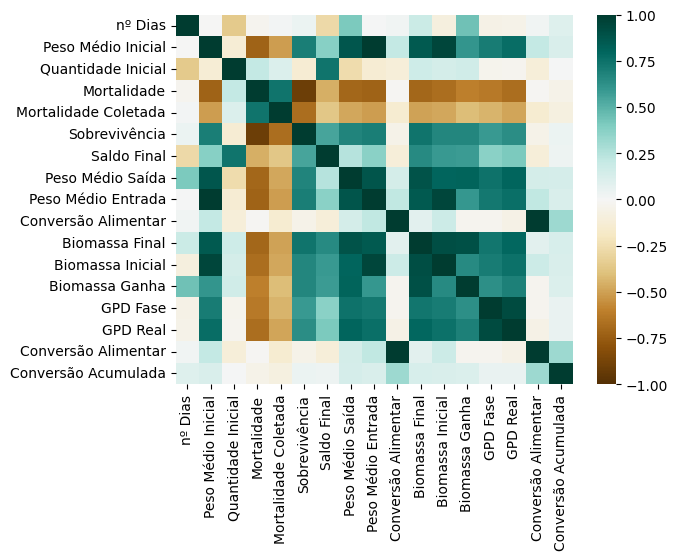

In [12]:
#temp_df = prod_fase2[num_list]
sns.heatmap(prod_fase2.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

In [13]:
prod_fase3 = temp_num1[temp_num1['Fase'] == 'Fase 3']
prod_fase3.describe()

,nº Dias,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Peso Médio Saída,Peso Médio Entrada,Conversão Alimentar,Biomassa Final,Biomassa Inicial,Biomassa Ganha,GPD Fase,GPD Real,Conversão Alimentar,Conversão Acumulada
count,652.000000,652.000000,652.000000,652.00000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,66.871166,79.698160,8018.268405,1347.07362,439.644172,83.601955,6697.127301,369.754080,79.422465,1.752920,2484.442542,629.361228,1855.081314,4.481513,4.454269,1.752920,1.552436
std,15.977479,31.856657,722.855880,748.50936,396.147910,10.041528,941.415978,52.428294,31.010559,0.471693,534.192534,231.342619,500.445308,1.122643,0.858230,0.471693,0.393192
min,22.000000,18.000000,4001.000000,51.00000,3.000000,51.987805,2623.000000,224.860909,27.743171,0.679229,842.348000,217.750000,194.962000,2.052131,1.993773,0.679229,0.657173
25%,55.000000,58.000000,8100.000000,758.75000,141.750000,77.718196,6232.750000,329.730448,58.300210,1.443402,2147.267750,472.023700,1538.215500,3.865511,3.894434,1.443402,1.349497
50%,65.000000,76.000000,8100.000000,1267.00000,332.000000,84.072612,6857.000000,360.464013,75.859568,1.581604,2422.747500,617.744400,1801.966000,4.412892,4.402566,1.581604,1.460644
75%,78.000000,99.000000,8180.000000,1798.50000,638.750000,90.507942,7340.250000,407.125481,98.015062,1.916563,2857.929000,784.603250,2188.264500,5.039770,5.048565,1.916563,1.674434
max,133.000000,201.000000,10788.000000,3937.00000,2377.000000,163.833851,9396.000000,547.998224,192.000000,4.515163,4055.392000,1526.499000,3255.463000,21.704905,7.702867,4.515163,8.112428


C:\Users\crist\AppData\Local\Temp\ipykernel_15612\1767541517.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(prod_fase3.corr(),


<Axes: >

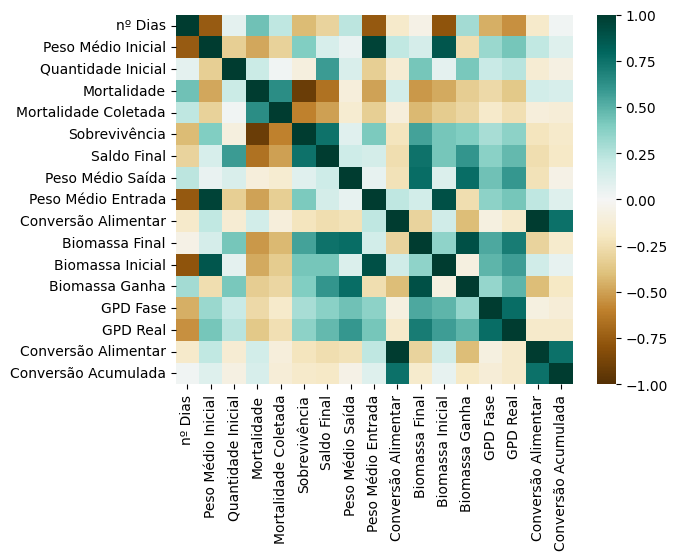

In [14]:
#temp_df = prod_fase2[num_list]
sns.heatmap(prod_fase3.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

In [15]:
prod_fase4 = temp_num1[temp_num1['Fase'] == 'Fase 4']
prod_fase4.describe()

,nº Dias,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Peso Médio Saída,Peso Médio Entrada,Conversão Alimentar,Biomassa Final,Biomassa Inicial,Biomassa Ganha,GPD Fase,GPD Real,Conversão Alimentar,Conversão Acumulada
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,79.266547,395.924687,7481.150268,146.885510,96.762075,101.651982,7610.423971,917.090861,397.073346,1.879222,6921.020867,3007.259371,3921.360835,6.687877,6.676532,1.879222,1.754221
std,23.958719,92.800768,1626.488674,174.792015,89.562310,6.974205,1772.723602,95.299883,91.084673,0.318515,1575.518944,990.612147,1207.497712,0.965029,0.952218,0.318515,1.162793
min,33.000000,82.000000,3028.000000,0.000000,0.000000,82.632020,2789.000000,711.000000,81.192099,1.228856,2496.678000,657.656000,799.484000,3.952262,3.360075,1.228856,-25.249060
25%,60.000000,336.150000,7118.000000,32.000000,25.000000,98.279644,7438.000000,844.000000,335.025157,1.665177,6448.000000,2391.943500,3037.458000,6.056773,6.030510,1.665177,1.635007
50%,75.000000,390.000000,8050.000000,96.000000,71.000000,101.012516,8079.000000,900.000000,392.001618,1.782333,7295.127000,3077.182000,3809.078000,6.654545,6.662924,1.782333,1.751977
75%,96.500000,453.500000,8148.500000,207.000000,140.000000,104.460526,8588.500000,1000.000000,457.653847,2.040459,8003.117500,3790.712500,4727.267350,7.232572,7.265703,2.040459,1.964137
max,172.000000,656.000000,11930.000000,2072.000000,822.000000,166.161473,12427.000000,1173.814607,638.706453,3.605343,11395.024000,5463.495000,8246.090000,10.309524,10.167249,3.605343,2.527344


C:\Users\crist\AppData\Local\Temp\ipykernel_15612\2982007669.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(prod_fase4.corr(),


<Axes: >

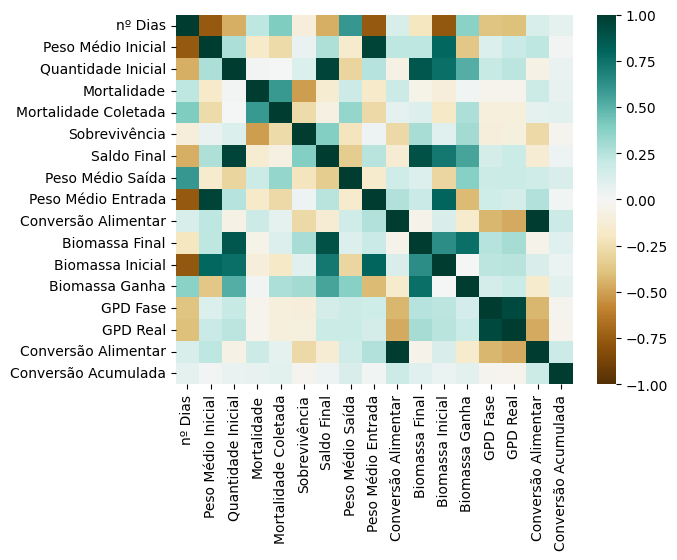

In [16]:
#temp_df = prod_fase2[num_list]
sns.heatmap(prod_fase4.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

In [17]:
#prod_fase = prod_num_final.groupby('Fase')
#prod_fase.describe(include='nº Dias')
#prod_fase.describe()


In [18]:
#prod=prod.select_dtypes(include='number').head()


In [19]:
#prod_cat=prod.select_dtypes(include='object')

## Saldo Final, Peso Médio Saída e Biomassa Final possuem 286 linhas zeradas

In [20]:
prod_num_286 =prod_num[prod_num['Saldo Final'] != 0]
prod_num_286.info()

NameError: name 'prod_num' is not defined

## Custo Total Entrada(Biomassa), Custo Total Entrada (Peixe), Custo Entrada/Kg e Custo Entrada/Unidades possuem 144 linhas zeradas


In [ ]:
num_list = ['ID Lote',
'nº Dias',
'Peso Médio Inicial',
'Quantidade Inicial',
'Mortalidade',
'Mortalidade Coletada',
'Sobrevivência',
'Saldo Final',
'Peso Médio Saída',
'Peso Médio Entrada',
'Biomassa Final',
'Biomassa Inicial',
'Biomassa Ganha',
'GPD Fase',
'GPD Real',
]

<Axes: >

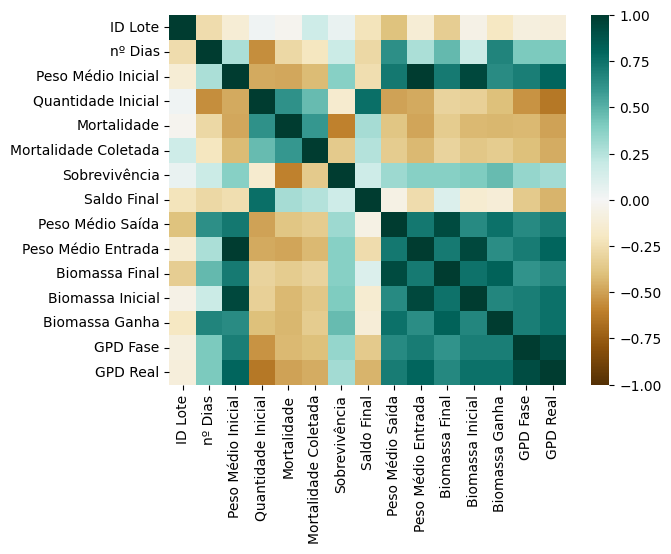

In [ ]:
#ind_new = ind[num_list]
temp_df = prod_num.reset_index(drop=True)
temp_df = prod_num[num_list]
sns.heatmap(temp_df.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')